## Grandient Boosting Modeling for Math ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import warnings 
warnings.filterwarnings('ignore')

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Data_Integration.ipynb](../processing/Data_Integration.ipynb) and [EDA.ipynb](../processing/EDA.ipynb)

In [3]:
df = pd.read_csv('../processing/DATA_Texas_District_v5.csv', sep=',', header=0)
print(df.shape)

(979, 126)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(979, 137)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Students Tested Reading - Grade 3 2018-2019',
            '% Students Tested Reading - Grade 4 2018-2019',
            '% Students Tested Reading - Grade 5 2018-2019',
            '% Students Tested Reading - Grade 6 2018-2019',
            '% Students Tested Reading - Grade 7 2018-2019',
            '% Students Tested Reading - Grade 8 2018-2019',
            '% Students Tested Reading - Grade 3 2020-2021',
            '% Students Tested Reading - Grade 4 2020-2021',
            '% Students Tested Reading - Grade 5 2020-2021',
            '% Students Tested Reading - Grade 6 2020-2021',
            '% Students Tested Reading - Grade 7 2020-2021',
            '% Students Tested Reading - Grade 8 2020-2021',
            'Average Score Reading All Grade 3 2018-2019',
            'Average Score Reading All Grade 4 2018-2019',
            'Average Score Reading All Grade 5 2018-2019',
            'Average Score Reading All Grade 6 2018-2019',
            'Average Score Reading All Grade 7 2018-2019',
            'Average Score Reading All Grade 8 2018-2019',
            'District #', 'County #']

df['Label'] = df['Label_Math'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(979, 114)


In [6]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,171,43
1,1,424,106
2,2,188,47


**Normalization**

In [7]:
# scaler = StandardScaler()

# scaler.fit(X_train[numerical_cols])
# X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with the Feature Sets selected from [Feature_Selection_Math.ipynb](../processing/Feature_Selection_Math.ipynb) ###

In [8]:
feature_selected = pd.read_csv('../Processing/Feature_Selection_Math_Results.csv', sep=',', header=0)
feature_selected = feature_selected[feature_selected['selected']==1]
methods = feature_selected.Method.unique().tolist() + ["No Reduction"]

for n, m in enumerate(methods):
    n_feat = len(columns) if m == "No Reduction" else feature_selected[feature_selected['Method']==m].shape[0]
    print('Feature Set {}: n={} from {}'.format(n+1, n_feat, m))

Feature Set 1: n=13 from Variance Threshold
Feature Set 2: n=54 from Regularization - Lasso
Feature Set 3: n=57 from Feature Importance - Random Forest
Feature Set 4: n=75 from Permutation Importance - Random Forest
Feature Set 5: n=107 from Permutation Importance - Ridge
Feature Set 6: n=56 from RFE - Ridge
Feature Set 7: n=57 from RFE - Random Forest
Feature Set 8: n=57 from SFS - KNN
Feature Set 9: n=57 from SFS - Ridge
Feature Set 10: n=114 from No Reduction


**n iteration for models**

In [9]:
def get_n_iter (param_grid):
    n_iter_ratio = 0.2
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter *= n_iter_ratio

    return int(n_iter)

### Modeling ###

In [10]:
rounds = 20

In [11]:
def model_report(estimator, param_grid, name, fit_params):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter=get_n_iter(param_grid)
    print('{} n_iter: {:0.0f}'.format(name, n_iter))     
    if name == 'CatBoost': n_iter=100
       
    for method in methods:
        features = columns if method == "No Reduction" else feature_selected[feature_selected['Method']==method]['feature'].unique().tolist()
            
        X_train2 = X_train.loc[:, features].copy()
        X_test2 = X_test.loc[:, features].copy()                        
        
        categorical_cols_inx=[features.index(f) for f in features if f in categorical_cols]
        if len(categorical_cols_inx) > 0:
            if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols_inx
            if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols_inx
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols_inx})
            if (name == 'XGBoost'):
                X_train2=X_train2.astype({features[c]: 'category' for c in categorical_cols_inx})
                X_test2=X_test2.astype({features[c]: 'category' for c in categorical_cols_inx})
        else: 
            if (name == 'LightGBM'): fit_params['categorical_feature']=None
            if (name == 'CatBoost'): fit_params['cat_features']=None
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})
              
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'HistGB': 
            grid.fit(X_train2, y_train)
        elif name == 'LightGBM':
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
        else:
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
       
        if name == 'XGBoost': grid.best_estimator_.save_model("categorical-model.json")
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [12]:
results = pd.DataFrame()

**CatBoost**

In [13]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
        'depth': [3, 6, 9],
        'min_data_in_leaf': [1, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
        'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, 
                               loss_function='MultiClass', eval_metric="MultiClass", one_hot_max_size=4, border_count=254)
                               
result_report=model_report(estimator, params, 'CatBoost', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 432
CPU times: total: 2min 6s
Wall time: 3h 33min 39s


**XGBoost**

In [14]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

# fit_params = {'early_stopping_rounds': rounds,
#               'eval_metric': 'mlogloss'}

estimator = xgboost.XGBClassifier(seed=random_state, objective='multi:softproba', eval_metric='mlogloss', use_label_encoder=False, verbosity=0,
                                  num_class=3, tree_method="hist", early_stopping_rounds=rounds, enable_categorical=True, max_cat_to_onehot=4)

result_report=model_report(estimator, params, 'XGBoost', {})
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 777
[0]	validation_0-mlogloss:1.05217
[1]	validation_0-mlogloss:1.01746
[2]	validation_0-mlogloss:0.99076
[3]	validation_0-mlogloss:0.96981
[4]	validation_0-mlogloss:0.95252
[5]	validation_0-mlogloss:0.94122
[6]	validation_0-mlogloss:0.93020
[7]	validation_0-mlogloss:0.92180
[8]	validation_0-mlogloss:0.91477
[9]	validation_0-mlogloss:0.90923
[10]	validation_0-mlogloss:0.90564
[11]	validation_0-mlogloss:0.90217
[12]	validation_0-mlogloss:0.89896
[13]	validation_0-mlogloss:0.89679
[14]	validation_0-mlogloss:0.89399
[15]	validation_0-mlogloss:0.89189
[16]	validation_0-mlogloss:0.89008
[17]	validation_0-mlogloss:0.88830
[18]	validation_0-mlogloss:0.88690
[19]	validation_0-mlogloss:0.88606
[20]	validation_0-mlogloss:0.88493
[21]	validation_0-mlogloss:0.88337
[22]	validation_0-mlogloss:0.88240
[23]	validation_0-mlogloss:0.88126
[24]	validation_0-mlogloss:0.87986
[25]	validation_0-mlogloss:0.87927
[26]	validation_0-mlogloss:0.87837
[27]	validation_0-mlogloss:0.87730
[28]	valid

[63]	validation_0-mlogloss:0.73675
[64]	validation_0-mlogloss:0.73703
[65]	validation_0-mlogloss:0.73799
[66]	validation_0-mlogloss:0.73837
[0]	validation_0-mlogloss:1.02932
[1]	validation_0-mlogloss:0.97340
[2]	validation_0-mlogloss:0.93364
[3]	validation_0-mlogloss:0.89878
[4]	validation_0-mlogloss:0.87164
[5]	validation_0-mlogloss:0.85174
[6]	validation_0-mlogloss:0.83378
[7]	validation_0-mlogloss:0.82442
[8]	validation_0-mlogloss:0.81092
[9]	validation_0-mlogloss:0.80124
[10]	validation_0-mlogloss:0.79582
[11]	validation_0-mlogloss:0.78783
[12]	validation_0-mlogloss:0.78437
[13]	validation_0-mlogloss:0.77864
[14]	validation_0-mlogloss:0.77316
[15]	validation_0-mlogloss:0.77002
[16]	validation_0-mlogloss:0.76805
[17]	validation_0-mlogloss:0.76382
[18]	validation_0-mlogloss:0.76017
[19]	validation_0-mlogloss:0.75916
[20]	validation_0-mlogloss:0.75655
[21]	validation_0-mlogloss:0.75639
[22]	validation_0-mlogloss:0.75474
[23]	validation_0-mlogloss:0.75474
[24]	validation_0-mlogloss:0.7

[2]	validation_0-mlogloss:1.00073
[3]	validation_0-mlogloss:0.97611
[4]	validation_0-mlogloss:0.95541
[5]	validation_0-mlogloss:0.93561
[6]	validation_0-mlogloss:0.91926
[7]	validation_0-mlogloss:0.90339
[8]	validation_0-mlogloss:0.89090
[9]	validation_0-mlogloss:0.88081
[10]	validation_0-mlogloss:0.86987
[11]	validation_0-mlogloss:0.86272
[12]	validation_0-mlogloss:0.85353
[13]	validation_0-mlogloss:0.84710
[14]	validation_0-mlogloss:0.83985
[15]	validation_0-mlogloss:0.83547
[16]	validation_0-mlogloss:0.82901
[17]	validation_0-mlogloss:0.82590
[18]	validation_0-mlogloss:0.82041
[19]	validation_0-mlogloss:0.81530
[20]	validation_0-mlogloss:0.81142
[21]	validation_0-mlogloss:0.80834
[22]	validation_0-mlogloss:0.80566
[23]	validation_0-mlogloss:0.80250
[24]	validation_0-mlogloss:0.79838
[25]	validation_0-mlogloss:0.79645
[26]	validation_0-mlogloss:0.79573
[27]	validation_0-mlogloss:0.79248
[28]	validation_0-mlogloss:0.78940
[29]	validation_0-mlogloss:0.78840
[30]	validation_0-mlogloss:0

**LightGBM**

In [15]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="multiclass", metric="multi_logloss", verbosity=-1, silent=True, force_col_wise=True,
                               num_class=3, is_unbalance=True, max_cat_threshold=32)
                               
result_report=model_report(estimator, params, 'LightGBM', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 777
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 1.00541
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 1.00316
[3]	valid_0's multi_logloss: 1.00093
[4]	valid_0's multi_logloss: 0.998747
[5]	valid_0's multi_logloss: 0.996558
[6]	valid_0's multi_logloss: 0.99445
[7]	valid_0's multi_logloss: 0.992397
[8]	valid_0's multi_logloss: 0.99032
[9]	valid_0's multi_logloss: 0.988313
[10]	valid_0's multi_logloss: 0.98631
[11]	valid_0's multi_logloss: 0.98438
[12]	valid_0's multi_logloss: 0.98247
[13]	valid_0's multi_logloss: 0.980562
[14]	valid_0's multi_logloss: 0.978765
[15]	valid_0's multi_logloss: 0.976932
[16]	valid_0's multi_logloss: 0.975143
[17]	valid_0's multi_logloss: 0.973387
[18]	valid_0's multi_logloss: 0.971708
[19]	valid_0's multi_logloss: 0.970014
[20]	valid_0's multi_logloss: 0.968352
[21]	valid_0's mult

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.94584
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.898421
[3]	valid_0's multi_logloss: 0.86479
[4]	valid_0's multi_logloss: 0.839835
[5]	valid_0's multi_logloss: 0.82059
[6]	valid_0's multi_logloss: 0.808342
[7]	valid_0's multi_logloss: 0.796054
[8]	valid_0's multi_logloss: 0.790098
[9]	valid_0's multi_logloss: 0.782928
[10]	valid_0's multi_logloss: 0.773394
[11]	valid_0's multi_logloss: 0.764973
[12]	valid_0's multi_logloss: 0.760813
[13]	valid_0's multi_logloss: 0.757889
[14]	valid_0's multi_logloss: 0.754508
[15]	valid_0's multi_logloss: 0.751853
[16]	valid_0's multi_logloss: 0.752229
[17]	valid_0's multi_logloss: 0.749354
[18]	valid_0's multi_logloss: 0.750738
[19]	valid_0's multi_logloss: 0.747855
[20]	valid_0's multi_logloss: 0.743344
[21]	valid_0's multi_logloss: 0

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's multi_logloss: 0.918775
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.860415
[3]	valid_0's multi_logloss: 0.823484
[4]	valid_0's multi_logloss: 0.79928
[5]	valid_0's multi_logloss: 0.789535
[6]	valid_0's multi_logloss: 0.775083
[7]	valid_0's multi_logloss: 0.76626
[8]	valid_0's multi_logloss: 0.75858
[9]	valid_0's multi_logloss: 0.752064
[10]	valid_0's multi_logloss: 0.751317
[11]	valid_0's multi_logloss: 0.753701
[12]	valid_0's multi_logloss: 0.747712
[13]	valid_0's multi_logloss: 0.747205
[14]	valid_0's multi_logloss: 0.748654
[15]	valid_0's multi_logloss: 0.750825
[16]	valid_0's multi_logloss: 0.748137
[17]	valid_0's multi_logloss: 0.749482
[18]	valid_0's multi_logloss: 0.749243
[19]	valid_0's multi_logloss: 0.745513
[20]	valid_0's multi_logloss: 0.745067
[21]	valid_0's multi_logloss: 0.748

**HistGradientBoosting**

In [16]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, 'HistGB', {})
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 432
CPU times: total: 1min 48s
Wall time: 16min 56s


## Result ##

In [17]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
33,HistGB,Permutation Importance - Random Forest,75,0.688776,0.458386,0.670205,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,..."
4,CatBoost,Permutation Importance - Ridge,107,0.683673,0.456347,0.636635,"{'random_strength': 5, 'min_data_in_leaf': 5, ..."
2,CatBoost,Feature Importance - Random Forest,57,0.678571,0.445382,0.632458,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
1,CatBoost,Regularization - Lasso,54,0.678571,0.441257,0.640568,"{'random_strength': 0, 'min_data_in_leaf': 10,..."
5,CatBoost,RFE - Ridge,56,0.678571,0.438005,0.649121,"{'random_strength': 10, 'min_data_in_leaf': 5,..."
22,LightGBM,Feature Importance - Random Forest,57,0.673469,0.433287,0.627111,"{'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estima..."
34,HistGB,Permutation Importance - Ridge,107,0.673469,0.430530,0.653065,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,..."
23,LightGBM,Permutation Importance - Random Forest,75,0.673469,0.429961,0.634305,"{'reg_lambda': 10, 'reg_alpha': 0, 'n_estimato..."
35,HistGB,RFE - Ridge,56,0.673469,0.426959,0.647026,"{'min_samples_leaf': 30, 'max_leaf_nodes': 10,..."
14,XGBoost,Permutation Importance - Ridge,107,0.663265,0.410788,0.621526,"{'n_estimators': 100, 'min_child_weight': 0, '..."


In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
CatBoost,4
HistGB,3
LightGBM,2
XGBoost,1


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
54,1
56,2
57,2
75,2
107,3


**Accuracy, MCC and F1 Score**

In [20]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

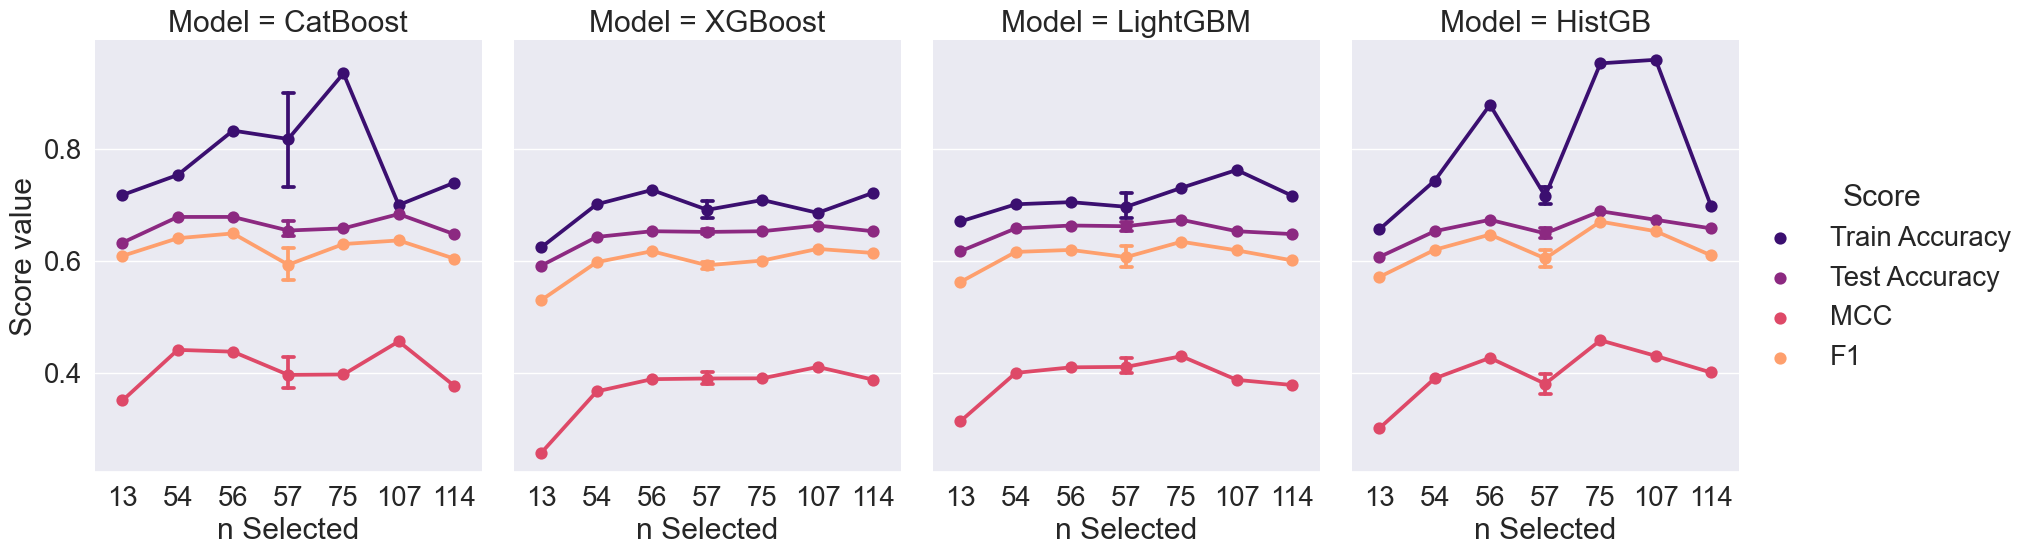

In [21]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [22]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

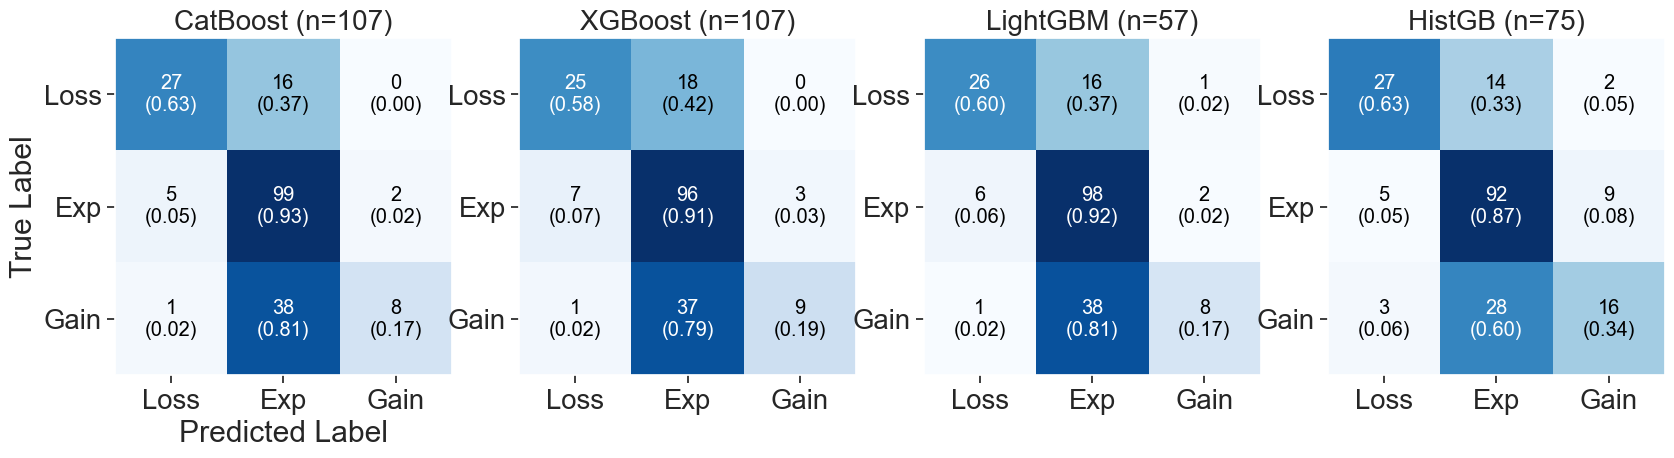

In [23]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

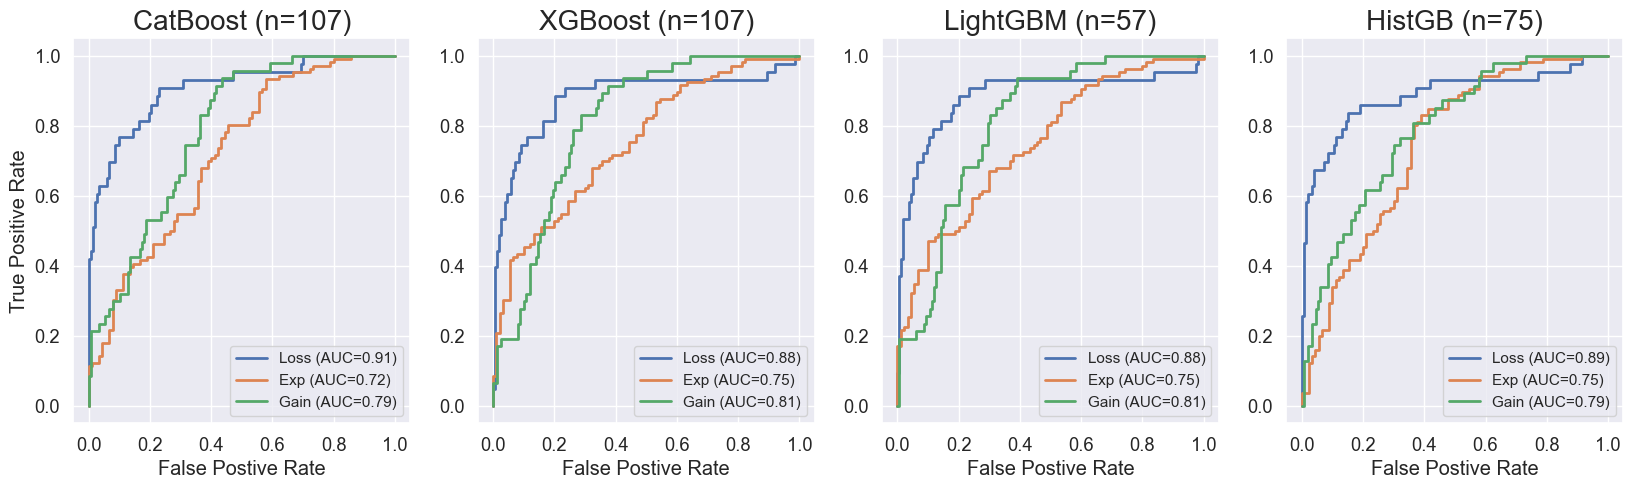

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

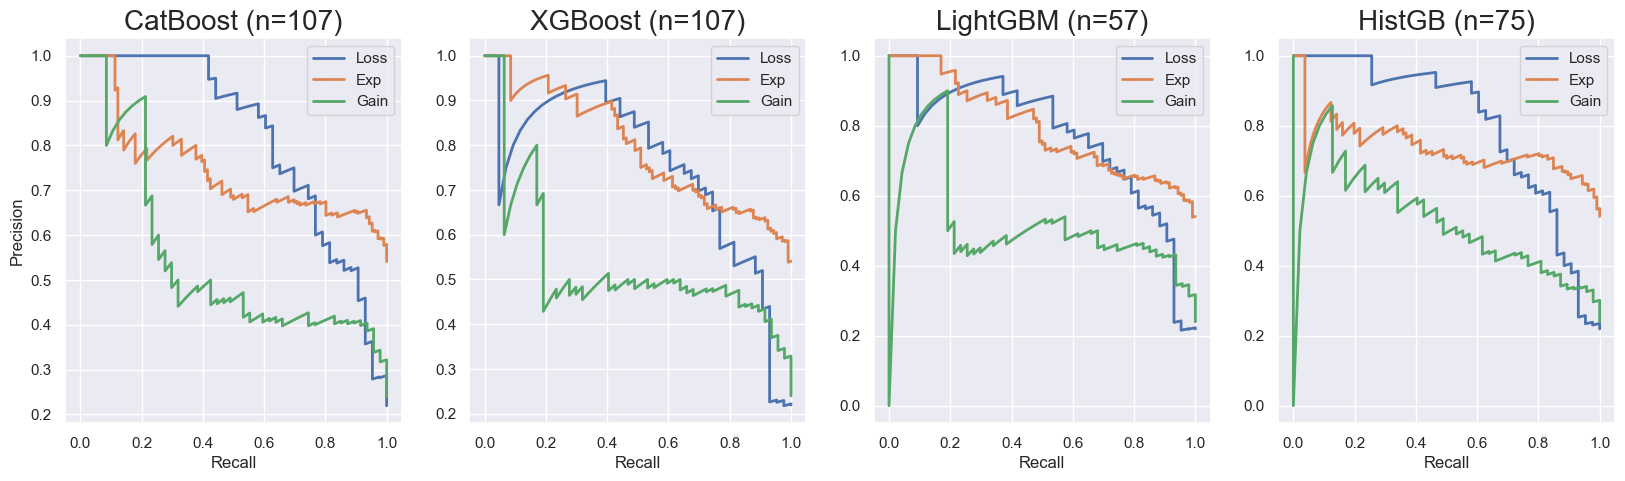

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [26]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=107) 
               precision    recall  f1-score   support

           0       0.82      0.63      0.71        43
           1       0.65      0.93      0.76       106
           2       0.80      0.17      0.28        47

    accuracy                           0.68       196
   macro avg       0.76      0.58      0.59       196
weighted avg       0.72      0.68      0.64       196

XGBoost (n=107) 
               precision    recall  f1-score   support

           0       0.76      0.58      0.66        43
           1       0.64      0.91      0.75       106
           2       0.75      0.19      0.31        47

    accuracy                           0.66       196
   macro avg       0.71      0.56      0.57       196
weighted avg       0.69      0.66      0.62       196

LightGBM (n=57) 
               precision    recall  f1-score   support

           0       0.79      0.60      0.68        43
           1       0.64      0.92      0.76       106
           2       0

In [27]:
results.sort_values(by=['MCC'], ascending=False).to_csv('Modeling_GB_Math.csv')